In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
import scipy
from scipy.signal import spectrogram
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate, Dropout, BatchNormalization, Bidirectional,Conv1D, Conv2D, Flatten
from keras.layers import LSTM, GRU

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

%matplotlib inline

In [2]:
eeg_data = "/content/EEG_data.csv"
demo_data = "/content/demographic_info.csv"

In [3]:
eeg_df = pd.read_csv(eeg_data)
eeg_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [4]:
eeg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


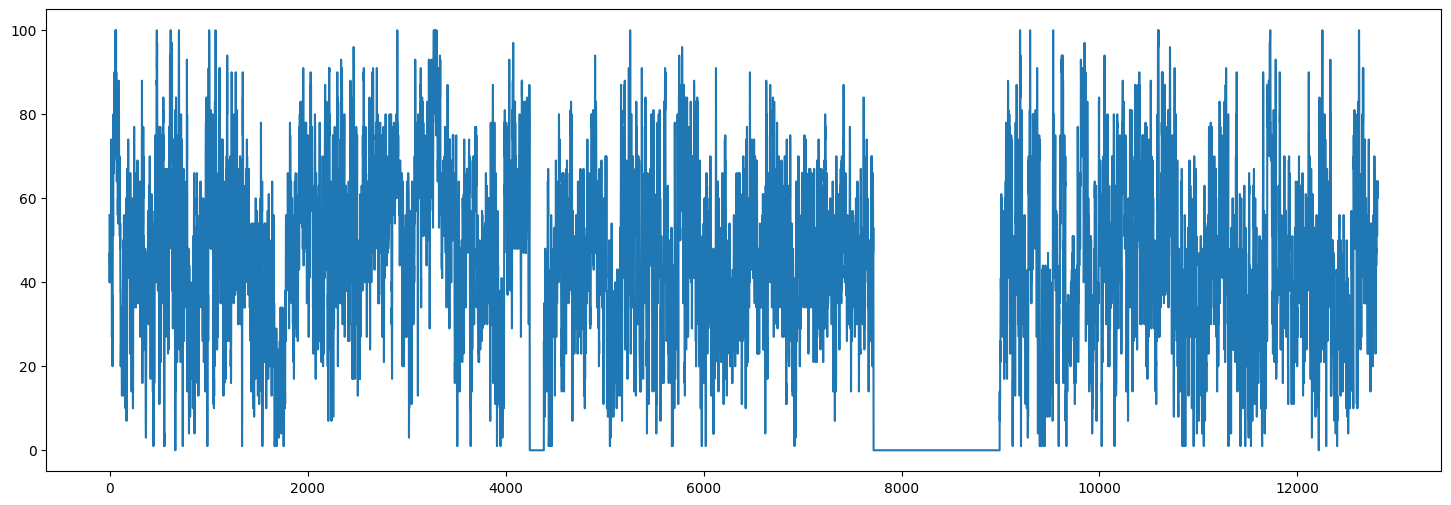

In [5]:
eeg_df['Attention'].plot(figsize=(18,6))
plt.show()

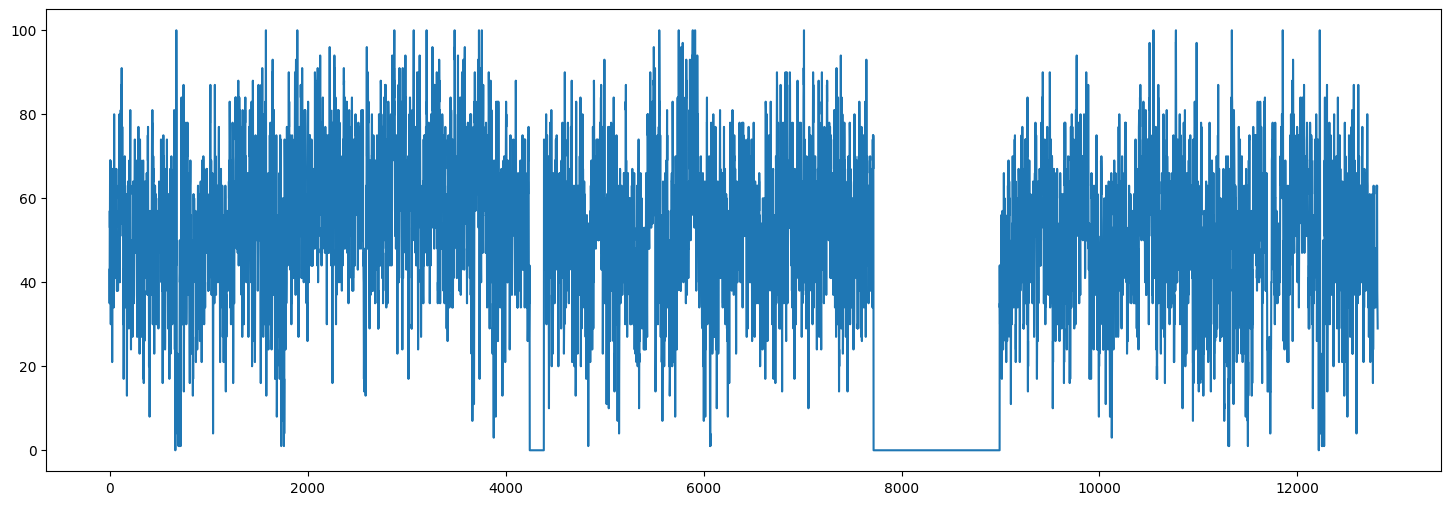

In [6]:
eeg_df['Mediation'].plot(figsize=(18,6))
plt.show()

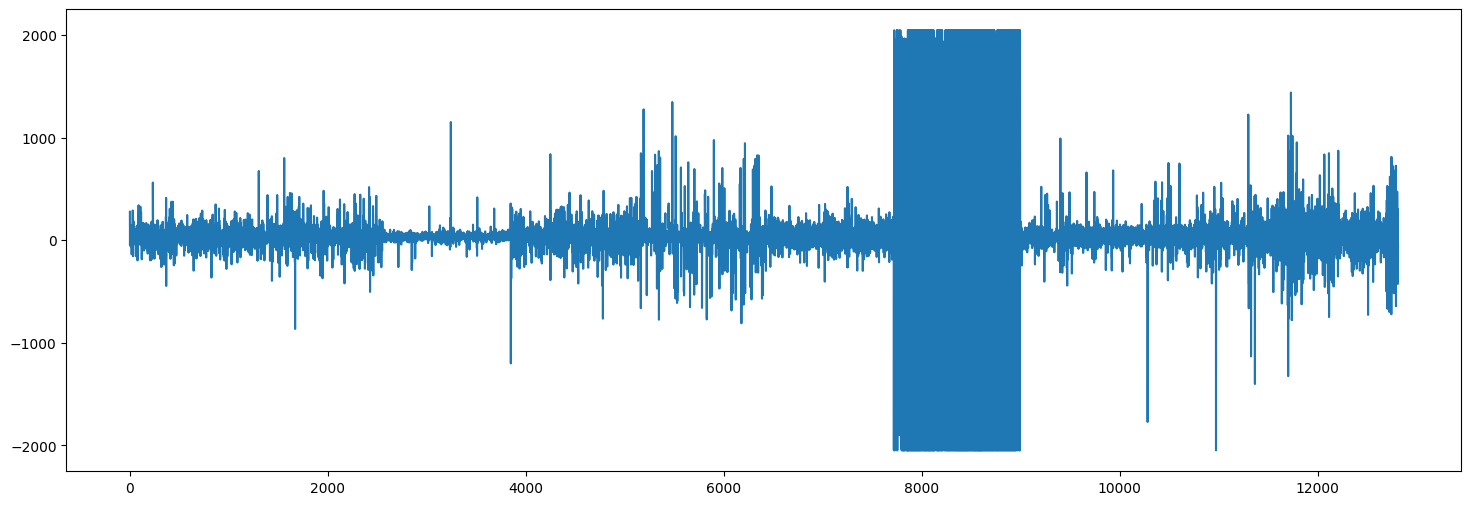

In [7]:
eeg_df['Raw'].plot(figsize=(18,6))
plt.show()

In [8]:
eeg_df.groupby(['SubjectID', 'VideoID']).filter(lambda x: x['Attention'].sum()==0).groupby(['SubjectID', 'VideoID']).size()

SubjectID  VideoID
3.0        3.0        144
6.0        0.0        140
           1.0        142
           2.0        122
           3.0        116
           4.0        144
           5.0        123
           6.0        116
           7.0        113
           8.0        122
           9.0        137
dtype: int64

In [9]:
data = eeg_df.query('(SubjectID != 6) & (SubjectID != 3 | VideoID !=3)')
len(data), len(eeg_df)

(11392, 12811)

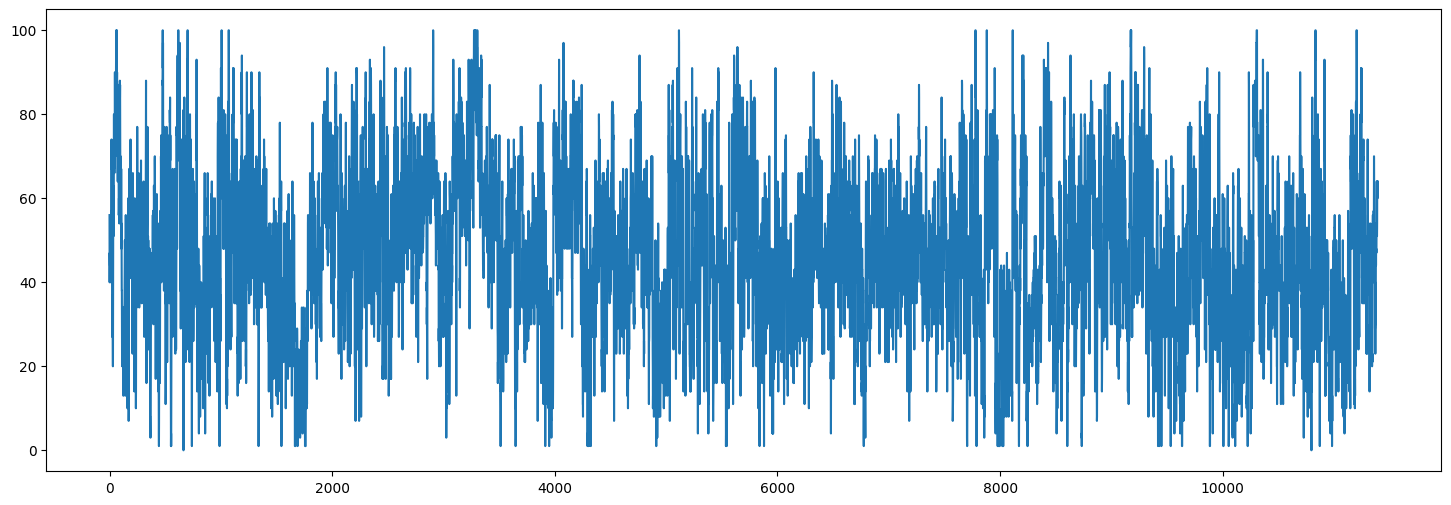

In [10]:
data.reset_index()['Attention'].plot(figsize=(18,6))
plt.show()

<Axes: >

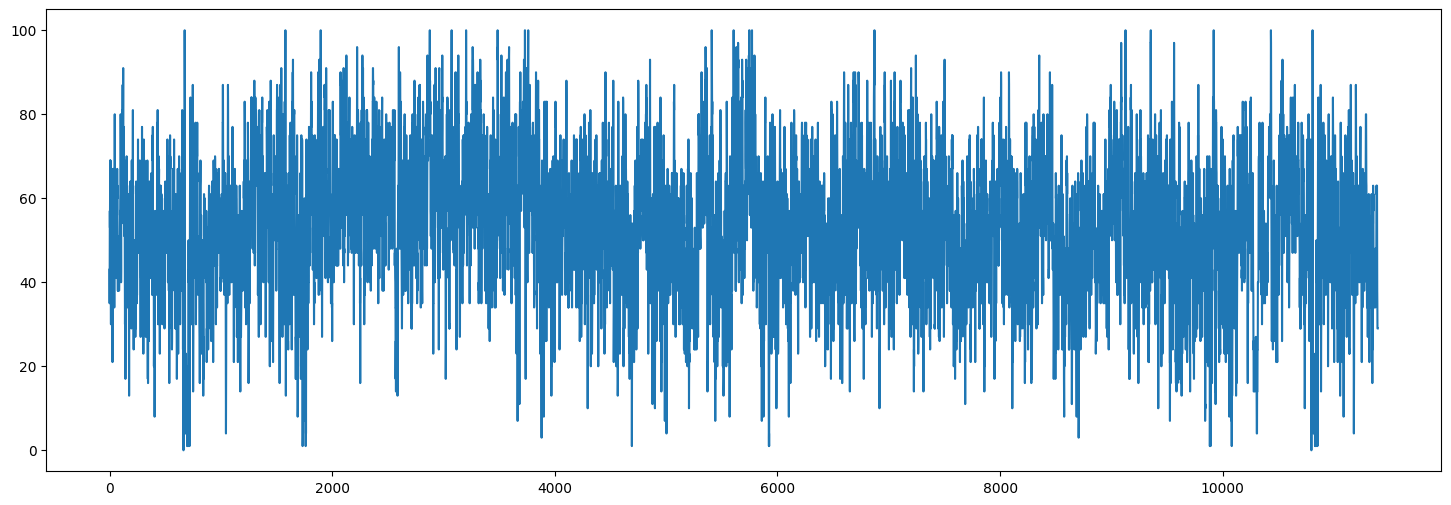

In [11]:
data.reset_index()['Mediation'].plot(figsize=(18,6))

<Axes: >

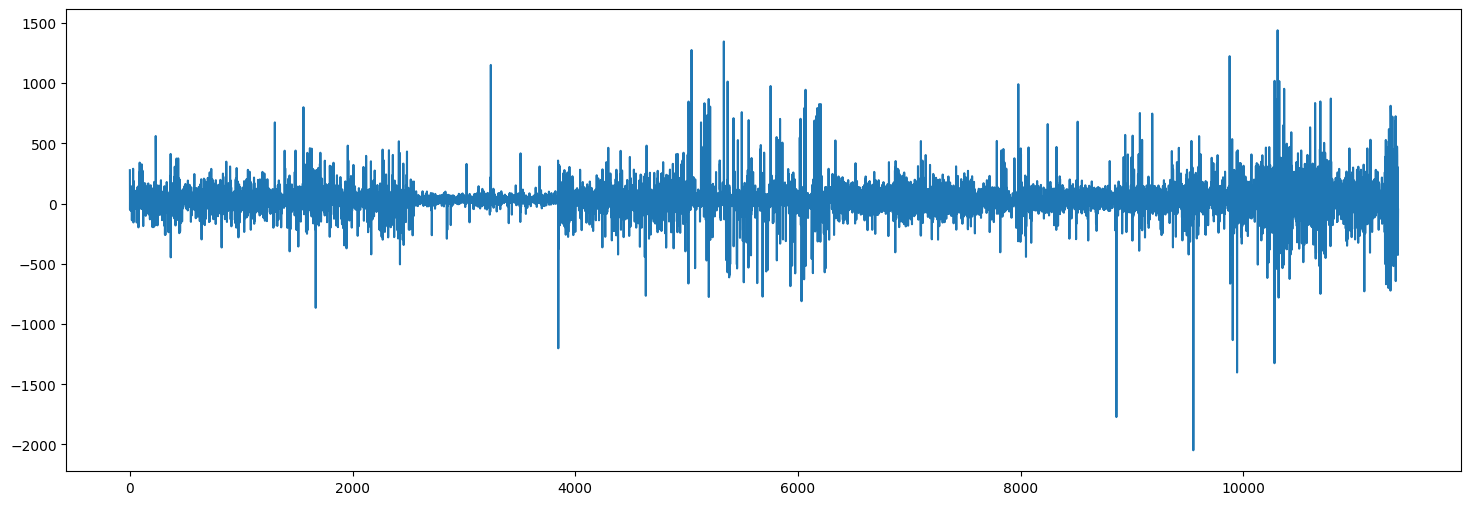

In [12]:
data.reset_index()['Raw'].plot(figsize=(18,6))

In [13]:
corr = data.corr()
corr

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
SubjectID,1.000000,-0.008905,-0.113540,-0.092033,-0.001363,0.206455,0.111413,0.111729,0.140214,0.059720,0.144859,0.054789,0.029171,-0.008334,0.014027
VideoID,-0.008905,1.000000,-0.071697,-0.005977,-0.000819,0.003283,0.017466,0.024436,-0.003978,0.023950,-0.025139,-0.001777,0.017863,0.872185,0.014883
Attention,-0.113540,-0.071697,1.000000,0.162696,-0.008388,-0.237335,-0.272586,-0.187214,-0.156197,-0.125265,0.018580,-0.074249,-0.040691,-0.027861,-0.200929
Mediation,-0.092033,-0.005977,0.162696,1.000000,0.016321,-0.088904,-0.168171,0.065489,0.044051,-0.049912,-0.089450,-0.074629,-0.094584,-0.015472,-0.087938
Raw,-0.001363,-0.000819,-0.008388,0.016321,1.000000,-0.008388,-0.003858,-0.014944,-0.011935,-0.044504,-0.018658,-0.011208,-0.023205,-0.001651,0.000167
Delta,0.206455,0.003283,-0.237335,-0.088904,-0.008388,1.000000,0.485276,0.434420,0.415134,0.410677,0.385174,0.392043,0.310033,0.009265,0.159459
Theta,0.111413,0.017466,-0.272586,-0.168171,-0.003858,0.485276,1.000000,0.600374,0.584821,0.597776,0.491882,0.486883,0.415539,0.019975,0.148249
Alpha1,0.111729,0.024436,-0.187214,0.065489,-0.014944,0.434420,0.600374,1.000000,0.557952,0.561410,0.461468,0.485648,0.376634,0.026873,0.120295
Alpha2,0.140214,-0.003978,-0.156197,0.044051,-0.011935,0.415134,0.584821,0.557952,1.000000,0.589906,0.557673,0.532398,0.365821,0.002110,0.101898
Beta1,0.059720,0.023950,-0.125265,-0.049912,-0.044504,0.410677,0.597776,0.561410,0.589906,1.000000,0.464235,0.492587,0.486344,0.027741,0.124998


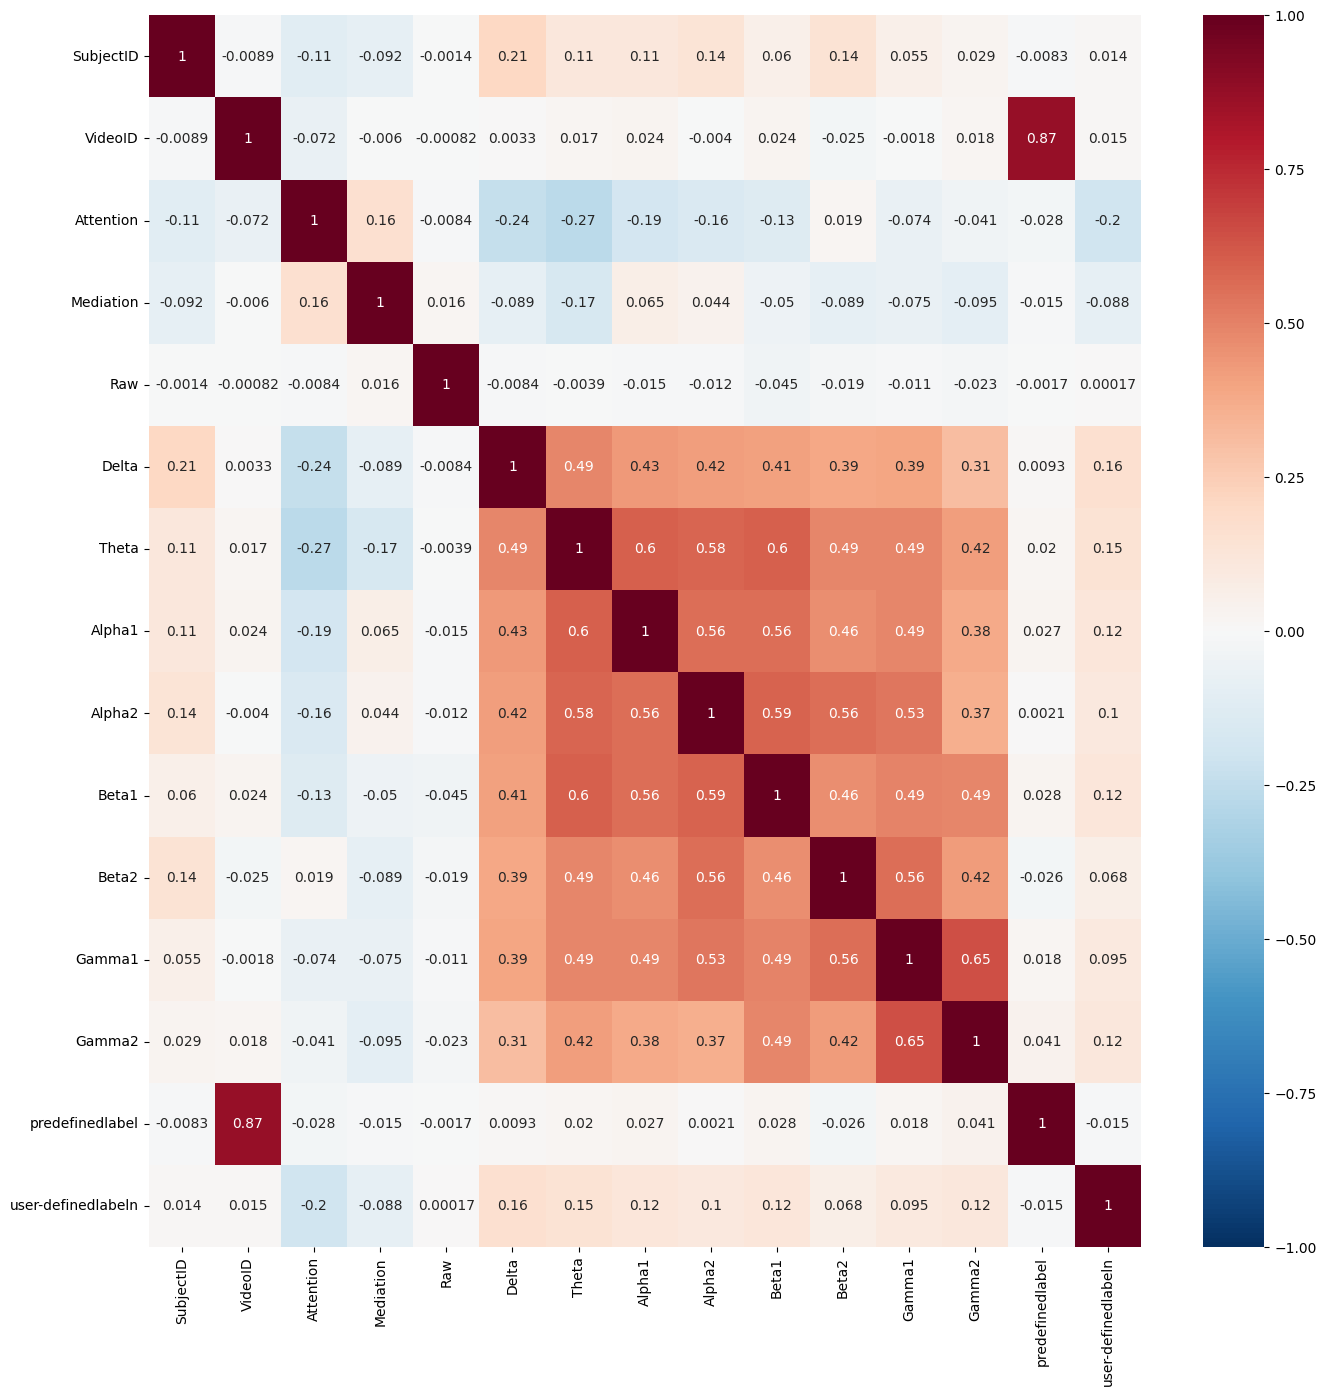

In [14]:
plt.figure(figsize = (16, 16))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="RdBu_r")
plt.show()

In [15]:
deltas = []
thetas = []
labels = []
sub_ids = data['SubjectID'].unique()
vid_ids = data['VideoID'].unique()

for sid in sub_ids:
  for vid in vid_ids:
    point = data.query('SubjectID ==' + str(sid) + ' & VideoID ==' + str(vid))
    if (len(point) > 0):
      labels.append(point['user-definedlabeln'].unique()[0])
      deltas.append(point['Delta'].values)
      thetas.append(point['Theta'].values)

In [16]:
print(len(deltas), len(thetas), len(labels))

89 89 89


In [17]:
seq_len = 144
deltas_fin=sequence.pad_sequences(deltas, maxlen=seq_len, padding='post', dtype='float', truncating='post')
thetas_fin=sequence.pad_sequences(thetas, maxlen=seq_len, padding='post', dtype='float', truncating='post')
deltas_fin = np.asarray(deltas_fin)
thetas_fin = np.asarray(thetas_fin)
labels = np.asarray(labels)

In [18]:
print(len(deltas_fin), len(thetas_fin), len(labels))

89 89 89


In [19]:
X_train_delta, X_test_delta, X_train_theta, X_test_theta, y_train, y_test = train_test_split(deltas_fin, thetas_fin, labels, test_size=0.1, random_state=42)
print(X_train_delta.shape, X_test_delta.shape, X_train_theta.shape, X_test_theta.shape, y_train.shape, y_test.shape)

(80, 144) (9, 144) (80, 144) (9, 144) (80,) (9,)


In [20]:
X_train_delta = np.reshape(X_train_delta, (X_train_delta.shape[0], 1, X_train_delta.shape[1]))
X_train_theta = np.reshape(X_train_theta, (X_train_theta.shape[0], 1, X_train_theta.shape[1]))
X_test_delta = np.reshape(X_test_delta, (X_test_delta.shape[0], 1, X_test_delta.shape[1]))
X_test_theta = np.reshape(X_test_theta, (X_test_theta.shape[0], 1, X_test_theta.shape[1]))
print(X_train_delta.shape, X_test_delta.shape, X_train_theta.shape, X_test_theta.shape, y_train.shape, y_test.shape)

(80, 1, 144) (9, 1, 144) (80, 1, 144) (9, 1, 144) (80,) (9,)


In [21]:
input_delta = Input((1,144), name='input_delta')
input_theta = Input((1,144), name='input_theta')
lstm_out_delta = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(input_delta)
lstm_out_theta = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(input_theta)
merged = concatenate([lstm_out_delta, lstm_out_theta])
out = Dense(64, activation='relu', kernel_initializer='he_uniform')(merged)
out = Dropout(0.5)(out)
main_out = Dense(1, activation='sigmoid')(out)

model3 = Model([input_delta, input_theta], main_out)
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_delta (InputLayer)    [(None, 1, 144)]             0         []                            
                                                                                                  
 input_theta (InputLayer)    [(None, 1, 144)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 64)                   53504     ['input_delta[0][0]']         
                                                                                                  
 lstm_1 (LSTM)               (None, 64)                   53504     ['input_theta[0][0]']         
                                                                                              

In [22]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model3.fit(x=[X_train_delta, X_train_theta], batch_size=1, y=y_train, epochs=10, validation_split=0.1)

Epoch 1/10
72/72 [==============================] - 6s 13ms/step - loss: 0.7816 - accuracy: 0.5556 - val_loss: 0.6424 - val_accuracy: 0.8750
Epoch 2/10
72/72 [==============================] - 0s 4ms/step - loss: 0.7665 - accuracy: 0.6389 - val_loss: 0.6453 - val_accuracy: 0.7500
Epoch 3/10
72/72 [==============================] - 0s 5ms/step - loss: 0.6595 - accuracy: 0.6111 - val_loss: 0.6090 - val_accuracy: 0.7500
Epoch 4/10
72/72 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.5278 - val_loss: 0.6372 - val_accuracy: 0.7500
Epoch 5/10
72/72 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.5417 - val_loss: 0.6739 - val_accuracy: 0.7500
Epoch 6/10
72/72 [==============================] - 0s 4ms/step - loss: 0.6558 - accuracy: 0.5833 - val_loss: 0.7223 - val_accuracy: 0.6250
Epoch 7/10
72/72 [==============================] - 0s 5ms/step - loss: 0.6082 - accuracy: 0.5833 - val_loss: 0.7266 - val_accuracy: 0.6250
Epoch 8/10
72/72 [=

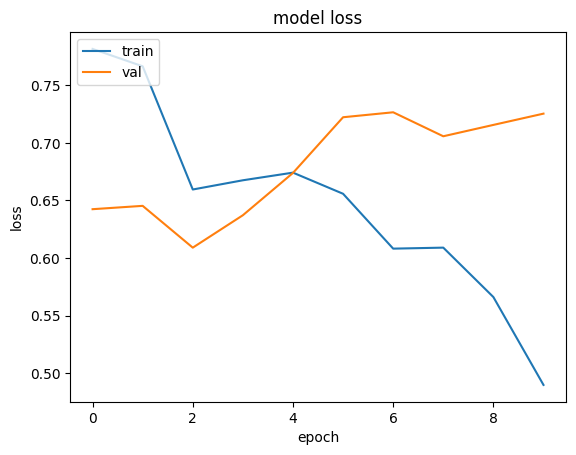

In [24]:
history = model3.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()